In [133]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import plotly.express as px  #Interactive plots
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus #Viz for decision trees
from io import StringIO  #Viz for decision trees
from IPython.display import Image #Viz for decision trees

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics, tree, linear_model
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [134]:
#Import data
HAI_tidy = pd.read_csv('.\data\HAI_tidy_Encoded.csv')
HAI_tidy.shape

(3096, 57)

In [135]:
#Drop anything with NA in the predictor col
HAI_tidy.dropna(subset=['HAI_5_SIR_Score'], inplace=True)
#HAI_tidy.info()

In [136]:
#Drop info cols
HAI_tidy.drop(['ZIP Code'], axis="columns", inplace=True)
HAI_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715 entries, 0 to 3095
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   HAI_1_DOPC                           1712 non-null   float64
 1   HAI_1_ELIGCASES                      1712 non-null   float64
 2   HAI_1_NUMERATOR                      1712 non-null   float64
 3   HAI_1_SIR_Score                      1675 non-null   float64
 4   HAI_2_DOPC                           1712 non-null   float64
 5   HAI_2_ELIGCASES                      1712 non-null   float64
 6   HAI_2_NUMERATOR                      1712 non-null   float64
 7   HAI_2_SIR_Score                      1689 non-null   float64
 8   HAI_3_DOPC                           1704 non-null   float64
 9   HAI_3_ELIGCASES                      1704 non-null   float64
 10  HAI_3_NUMERATOR                      1704 non-null   float64
 11  HAI_3_SIR_Score               

In [137]:
#Drop upper and lower limts from HAI data, and other columns that are highly internally correlated
HAI_baseLine = HAI_tidy[HAI_tidy.columns.drop(HAI_tidy.filter(regex='CILOWER|CIUPPER|.+STAR').columns )]

In [138]:
HAI_baseLine.columns

Index(['HAI_1_DOPC', 'HAI_1_ELIGCASES', 'HAI_1_NUMERATOR', 'HAI_1_SIR_Score',
       'HAI_2_DOPC', 'HAI_2_ELIGCASES', 'HAI_2_NUMERATOR', 'HAI_2_SIR_Score',
       'HAI_3_DOPC', 'HAI_3_ELIGCASES', 'HAI_3_NUMERATOR', 'HAI_3_SIR_Score',
       'HAI_4_DOPC', 'HAI_4_ELIGCASES', 'HAI_4_NUMERATOR', 'HAI_4_SIR_Score',
       'HAI_5_DOPC', 'HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR_Score',
       'HAI_6_DOPC', 'HAI_6_ELIGCASES', 'HAI_6_NUMERATOR', 'HAI_6_SIR_Score',
       'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE',
       'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
       'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'SEP_1', 'SEP_SH_3HR',
       'SEP_SH_6HR', 'SEV_SEP_3HR', 'SEV_SEP_6HR',
       'HAI_1_SIR_ComparedToNational_encode',
       'HAI_2_SIR_ComparedToNational_encode',
       'HAI_3_SIR_ComparedToNational_encode',
       'HAI_4_SIR_ComparedToNatio

## Train test split and choose X and y

In [139]:
#Since all HAI_5 data is highly related, it's 'cheating' to give any of it to the model, drop all columns from HAI_5
#May need to add the compared to national back if needed.
X = HAI_baseLine[HAI_baseLine.columns.drop(HAI_baseLine.filter(regex='HAI_5').columns )]
y_full = HAI_baseLine[['HAI_5_DOPC', 'HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR_Score']]
#I'm testing multiple Y values, and will assign a single one after the train test split for each run.

#Build into pipeline with grid search later - Impute NANs
#impute = SimpleImputer(missing_values=np.nan, strategy='mean')
#impute.fit(X)
#impute.transform(X)
X_defaults_mean = X.mean()
X = X.fillna(X_defaults_mean)

In [140]:
X_train, X_test, y_train_full, y_test_full = train_test_split(X, 
                                                    y_full, test_size=0.3, 
                                                    random_state=47)
y_train = y_train_full.HAI_5_SIR_Score
y_test = y_test_full.HAI_5_SIR_Score

print(X_train.columns) #removed target

Index(['HAI_1_DOPC', 'HAI_1_ELIGCASES', 'HAI_1_NUMERATOR', 'HAI_1_SIR_Score',
       'HAI_2_DOPC', 'HAI_2_ELIGCASES', 'HAI_2_NUMERATOR', 'HAI_2_SIR_Score',
       'HAI_3_DOPC', 'HAI_3_ELIGCASES', 'HAI_3_NUMERATOR', 'HAI_3_SIR_Score',
       'HAI_4_DOPC', 'HAI_4_ELIGCASES', 'HAI_4_NUMERATOR', 'HAI_4_SIR_Score',
       'HAI_6_DOPC', 'HAI_6_ELIGCASES', 'HAI_6_NUMERATOR', 'HAI_6_SIR_Score',
       'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE',
       'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
       'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'SEP_1', 'SEP_SH_3HR',
       'SEP_SH_6HR', 'SEV_SEP_3HR', 'SEV_SEP_6HR',
       'HAI_1_SIR_ComparedToNational_encode',
       'HAI_2_SIR_ComparedToNational_encode',
       'HAI_3_SIR_ComparedToNational_encode',
       'HAI_4_SIR_ComparedToNational_encode',
       'HAI_6_SIR_ComparedToNational_encode'],
      dtype='objec

## Decision tree

In [141]:
# Declare a variable called entr_model and use tree.DecisionTreeClassifier. 
treeReg = tree.DecisionTreeRegressor(min_samples_split=2)

#Fit and predict
treeReg.fit(X_train, y_train)
y_pred = treeReg.predict(X_test)

#Convert to series
y_pred = pd.Series(y_pred)

r2 -1.0873455279039237


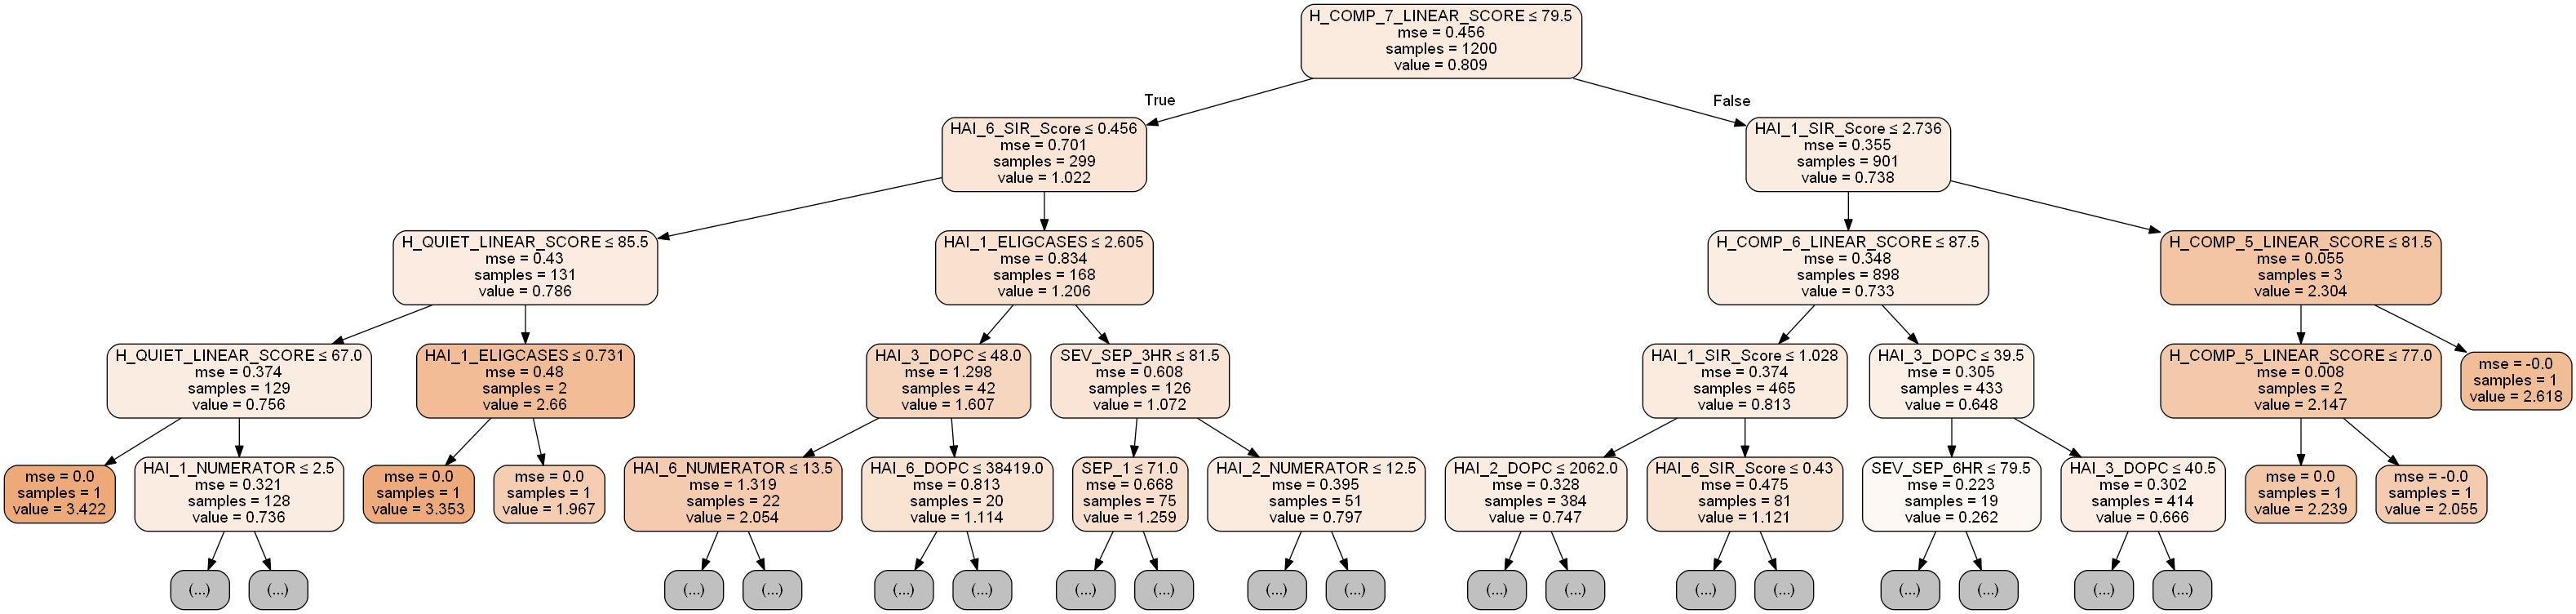

In [142]:
# function to display tree
def treeViz(model):
    # Now we want to visualize the tree
    dot_data = StringIO()

    # We can do so with export_graphviz
    tree.export_graphviz(model, out_file=dot_data, max_depth=4, 
                    filled=True, rounded=True,
                    special_characters=True, feature_names=X_train.columns) 

    # Alternatively for class_names use entr_model.classes_
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    return graph

graph = treeViz(treeReg)
print('r2', metrics.r2_score(y_test,y_pred))
Image(graph.create_png())


### Random Forest

In [143]:
RFreg = RandomForestRegressor(min_samples_leaf=5, random_state=42)
RFreg.fit(X_train, y_train)

y_pred = RFreg.predict(X_test)

r2: -0.01419169553812294


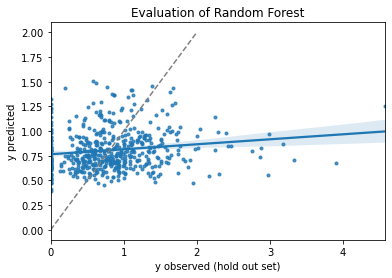

In [144]:
#modelResults(y_test, y_pred)
print('r2:', metrics.r2_score(y_test,y_pred))
#px.scatter(x=y_test, y=y_pred)
sns.regplot(x=y_test, y=y_pred, marker='.')
plt.title("Evaluation of Random Forest")
plt.xlabel('y observed (hold out set)')
plt.ylabel('y predicted')
plt.plot([0,1,2], [0,1,2], linestyle='dashed', color='gray');

## Linear regression

In [145]:
#Code task 4#
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

0.8090583333333325

In [146]:
#Fit the dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = train_mean * np.ones(len(y_test))

Check the "mean" model metrics __DUMMY__

In [147]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0010541157440056015)

In [148]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.49731080555555557, 0.45229762135922325)

In [149]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.4560547265972222, 0.38023078641248653)

Simplistic regression with imputation, __Actual data__

In [150]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)
#X_tr_scaled[:5,:5]

In [151]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [152]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

def printScore(y_train, y_test, y_tr_pred, y_te_pred):
    median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
    print("median_r2, train, test", median_r2)

    median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
    print("median_mae, train, test: ", median_mae)

    median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
    print("median_mae,  train, test", np.sqrt(median_mse))
    return None
printScore(y_train, y_test, y_tr_pred, y_te_pred)

median_r2, train, test (0.11262598479198305, -0.020746208397966814)
median_mae, train, test:  (0.4731537401045303, 0.45978542718437804)
median_mae,  train, test [0.63615337 0.62266399]


## Ridge regression

In [153]:
ridgeCV= linear_model.RidgeCV(cv=5).fit(X_tr_scaled, y_train)

median_r2, train, test (0.11167845739973803, -0.012918930271788698)
median_mae, train, test:  (0.473452101910869, 0.4576732386131004)
median_mae,  train, test [0.63649292 0.62027204]


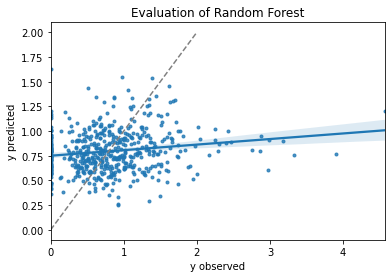

In [154]:
y_tr_pred = ridgeCV.predict(X_tr_scaled)
y_te_pred = ridgeCV.predict(X_te_scaled)

printScore(y_train, y_test, y_tr_pred, y_te_pred)

sns.regplot(x=y_test, y=y_te_pred, marker='.')
plt.title("Evaluation of Random Forest")
plt.xlabel('y observed')
plt.ylabel('y predicted')
plt.plot([0,1,2], [0,1,2], linestyle='dashed', color='gray');

Compute prediction for "numerator" and for SIR_score using the ridge regressor.

In [155]:
y_full.columns

Index(['HAI_5_DOPC', 'HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR_Score'], dtype='object')

In [156]:
#Try to predict another HAI_5 feature, which is used to compute the SIR score
y_train = y_train_full.HAI_5_NUMERATOR
y_test = y_test_full.HAI_5_NUMERATOR

ridgeCV = linear_model.RidgeCV(cv=5).fit(X_tr_scaled, y_train)

median_r2, train, test (0.7337320917777783, 0.7190547163077669)
median_mae, train, test:  (1.9868930144507329, 2.1051896858874635)
median_mae,  train, test [2.98553592 3.19492187]


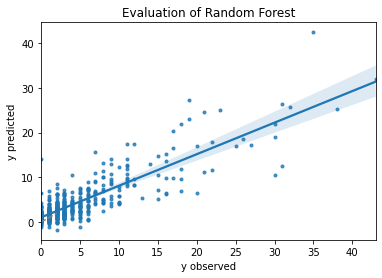

In [157]:
y_tr_pred_numerator = ridgeCV.predict(X_tr_scaled)
y_te_pred_numerator = ridgeCV.predict(X_te_scaled)

printScore(y_train, y_test, y_tr_pred_numerator, y_te_pred_numerator)

sns.regplot(x=y_test, y=y_te_pred_numerator, marker='.')
plt.title("Evaluation of Random Forest")
plt.xlabel('y observed')
plt.ylabel('y predicted')
plt.plot([0,1,2], [0,1,2], linestyle='dashed', color='gray');

Text(0, 0.5, 'y predicted')

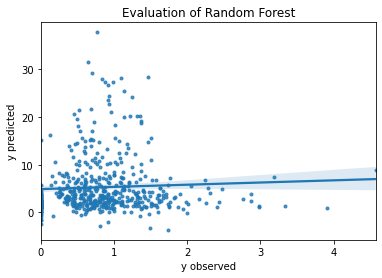

In [158]:
SIR_predict = y_te_pred_numerator / y_te_pred

sns.regplot(x=y_test_full.HAI_5_SIR_Score, y=SIR_predict, marker='.')
plt.title("Evaluation of Random Forest")
plt.xlabel('y observed')
plt.ylabel('y predicted')
#plt.plot([0,1,2], [0,1,2], linestyle='dashed', color='gray');

### To do:
* Add in initial poor fit with HAI_5_SIR_Score to show that I tried it and see the fit is very poor
* Reformat notebook into a 'story' and not a single program.

### Lessons learned

I found that the metric I was looking for had a very poor fit almost regardless of the algoritm.  This wasn't a surprise after doing EDA.  The solution was to compute two seperate features which are used to compute that algorithm, and were much easier to predict.